In [1]:
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version

1.8.1+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
import torch
assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8 if Colab changes its default version
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html


In [3]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# import some common detectron2 utilities

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [4]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode

def get_pothole_dicts(directory):
    classes = ['pothole']
    dataset_dicts = []
    for idx, filename in enumerate([file for file in os.listdir(directory) if file.endswith('.json')]):
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            img_anns = json.load(f)

        record = {}
        
        filename = os.path.join(directory, img_anns["imagePath"])
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = 720
        record["width"] = 1280
      
        annos = img_anns["shapes"]
        objs = []
        for anno in annos:
            px = [a[0] for a in anno['points']]
            py = [a[1] for a in anno['points']]
            poly = [(x, y) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(anno['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

from detectron2.data import DatasetCatalog, MetadataCatalog
for d in ["train"]:
    DatasetCatalog.register("pothole_" + d, lambda d=d: get_pothole_dicts("pothole_segmentation/" + d))
    MetadataCatalog.get("pothole_" + d).set(thing_classes=['pothole'])
    MetadataCatalog.get("pothole_" + d).set(thing_colors=[(204, 255, 255)])
pothole_metadata = MetadataCatalog.get("pothole_train")

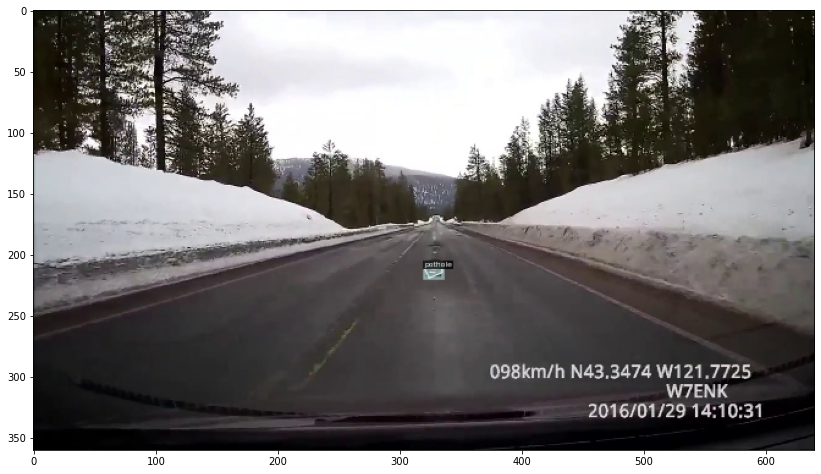

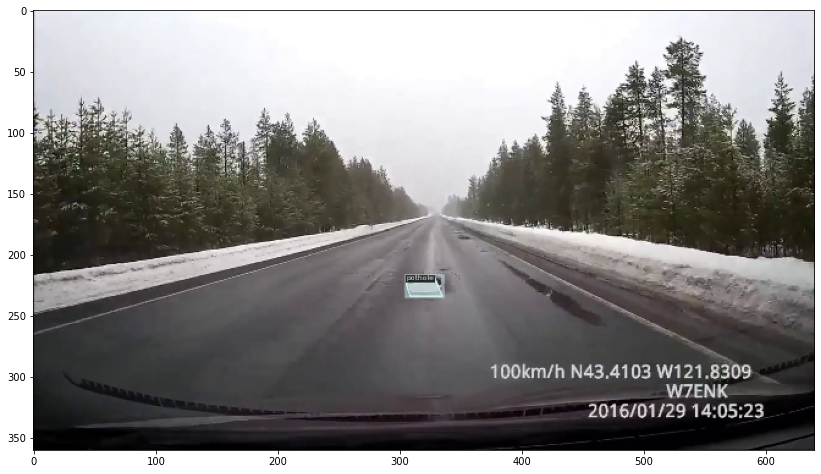

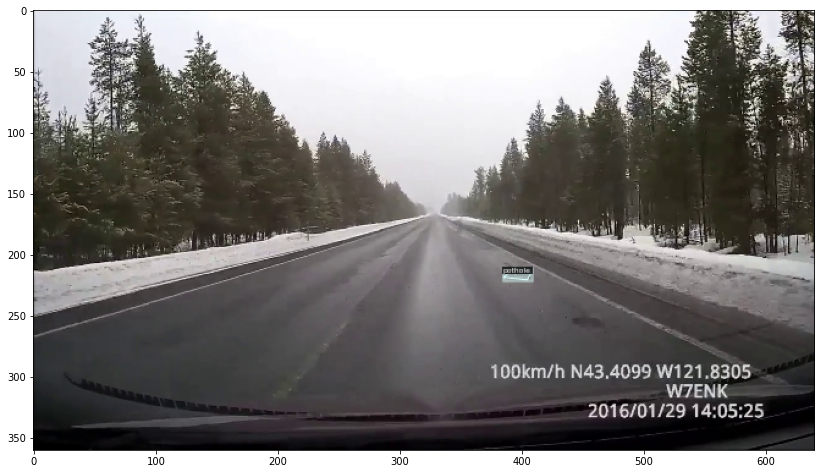

In [5]:
import random
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_pothole_dicts("pothole_segmentation/train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=pothole_metadata, scale=0.5,instance_mode=ColorMode.SEGMENTATION)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

In [6]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("pothole_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 2000
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[05/30 06:57:16 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:02, 84.5MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to i

[05/30 06:57:20 d2.engine.train_loop]: Starting training from iteration 0
[05/30 06:57:31 d2.utils.events]:  eta: 0:17:16  iter: 19  total_loss: 1.537  loss_cls: 0.7074  loss_box_reg: 0.05034  loss_mask: 0.6922  loss_rpn_cls: 0.07362  loss_rpn_loc: 0.01265  time: 0.5170  data_time: 0.0208  lr: 4.9953e-06  max_mem: 2674M
[05/30 06:57:42 d2.utils.events]:  eta: 0:17:10  iter: 39  total_loss: 1.397  loss_cls: 0.5803  loss_box_reg: 0.04123  loss_mask: 0.6876  loss_rpn_cls: 0.06637  loss_rpn_loc: 0.01263  time: 0.5188  data_time: 0.0079  lr: 9.9902e-06  max_mem: 2674M
[05/30 06:57:52 d2.utils.events]:  eta: 0:16:58  iter: 59  total_loss: 1.211  loss_cls: 0.3978  loss_box_reg: 0.05333  loss_mask: 0.6765  loss_rpn_cls: 0.0475  loss_rpn_loc: 0.01282  time: 0.5183  data_time: 0.0070  lr: 1.4985e-05  max_mem: 2674M
[05/30 06:58:03 d2.utils.events]:  eta: 0:16:55  iter: 79  total_loss: 1.093  loss_cls: 0.2622  loss_box_reg: 0.07633  loss_mask: 0.6662  loss_rpn_cls: 0.04778  loss_rpn_loc: 0.01206 

In [7]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import cv2

from detectron2.config import CfgNode
CfgNode.dump(cfg)
#save yor cfg in a .yaml file

"CUDNN_BENCHMARK: false\nDATALOADER:\n  ASPECT_RATIO_GROUPING: true\n  FILTER_EMPTY_ANNOTATIONS: true\n  NUM_WORKERS: 2\n  REPEAT_THRESHOLD: 0.0\n  SAMPLER_TRAIN: TrainingSampler\nDATASETS:\n  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000\n  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000\n  PROPOSAL_FILES_TEST: []\n  PROPOSAL_FILES_TRAIN: []\n  TEST: []\n  TRAIN:\n  - pothole_train\nGLOBAL:\n  HACK: 1.0\nINPUT:\n  CROP:\n    ENABLED: false\n    SIZE:\n    - 0.9\n    - 0.9\n    TYPE: relative_range\n  FORMAT: BGR\n  MASK_FORMAT: polygon\n  MAX_SIZE_TEST: 1333\n  MAX_SIZE_TRAIN: 1333\n  MIN_SIZE_TEST: 800\n  MIN_SIZE_TRAIN:\n  - 640\n  - 672\n  - 704\n  - 736\n  - 768\n  - 800\n  MIN_SIZE_TRAIN_SAMPLING: choice\n  RANDOM_FLIP: horizontal\nMODEL:\n  ANCHOR_GENERATOR:\n    ANGLES:\n    - - -90\n      - 0\n      - 90\n    ASPECT_RATIOS:\n    - - 0.5\n      - 1.0\n      - 2.0\n    NAME: DefaultAnchorGenerator\n    OFFSET: 0.0\n    SIZES:\n    - - 32\n    - - 64\n    - - 128\n    - - 256\n    - - 512\n  BACKBO

In [8]:
cfg = get_cfg()
cfg.merge_from_file('/content/my_cfg.yaml')

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.WEIGHTS = '/content/output/model_final.pth'
cfg.MODEL.DEVICE='cuda'
predictor=DefaultPredictor(cfg)

(418, 648)
(418, 649)
(418, 650)
(418, 651)
(418, 652)
(418, 653)
(418, 654)
(418, 655)
(418, 656)
(418, 657)
(418, 658)
(418, 659)
(418, 660)
(418, 661)
(418, 662)
(418, 663)
(418, 664)
(418, 665)
(418, 666)
(418, 667)
(418, 668)
(418, 669)
(418, 670)
(418, 671)
(418, 672)
(418, 673)
(418, 674)
(418, 675)
(418, 676)
(418, 677)
(418, 678)
(418, 679)
(418, 680)
(418, 681)
(418, 682)
(418, 683)
(418, 684)
(419, 645)
(419, 646)
(419, 647)
(419, 648)
(419, 649)
(419, 650)
(419, 651)
(419, 652)
(419, 653)
(419, 654)
(419, 655)
(419, 656)
(419, 657)
(419, 658)
(419, 659)
(419, 660)
(419, 661)
(419, 662)
(419, 663)
(419, 664)
(419, 665)
(419, 666)
(419, 667)
(419, 668)
(419, 669)
(419, 670)
(419, 671)
(419, 672)
(419, 673)
(419, 674)
(419, 675)
(419, 676)
(419, 677)
(419, 678)
(419, 679)
(419, 680)
(419, 681)
(419, 682)
(419, 683)
(419, 684)
(419, 685)
(419, 686)
(419, 687)
(419, 688)
(419, 689)
(419, 690)
(419, 691)
(420, 643)
(420, 644)
(420, 645)
(420, 646)
(420, 647)
(420, 648)
(420, 649)

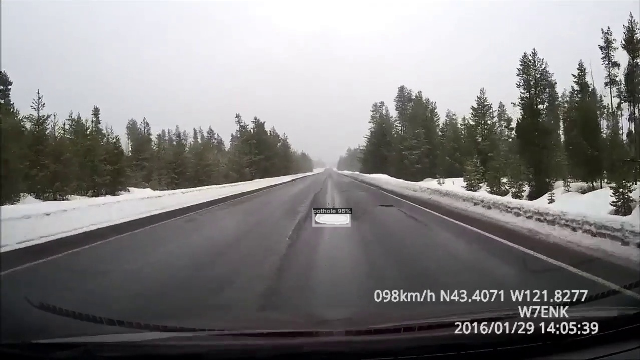

In [53]:
from detectron2.utils.visualizer import ColorMode
from google.colab.patches import cv2_imshow
import numpy
image=cv2.imread('/content/pothole_segmentation/train/875.jpg')
outputs = predictor(image)
mask=outputs['instances'].pred_masks
mask_np=mask.detach().cpu().numpy()
true_mask=(numpy.where(mask_np ==True))
listOfCoordinates= list(zip(true_mask[1],true_mask[2]))
for cord in listOfCoordinates:
    print(cord)
boxes=outputs['instances'].pred_boxes
for box in boxes:
  print(box.detach().cpu().numpy())
v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.5,instance_mode=ColorMode.SEGMENTATION)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

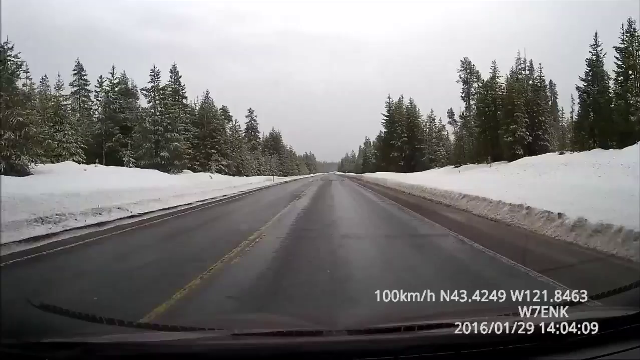

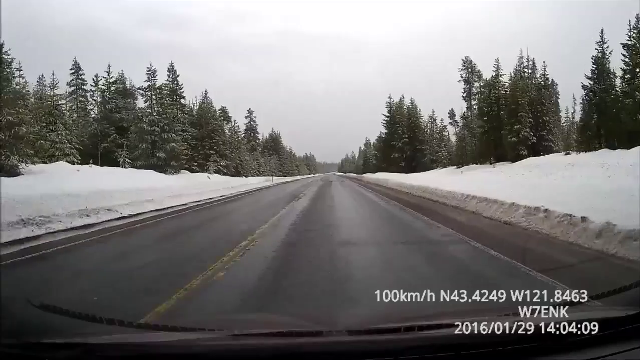

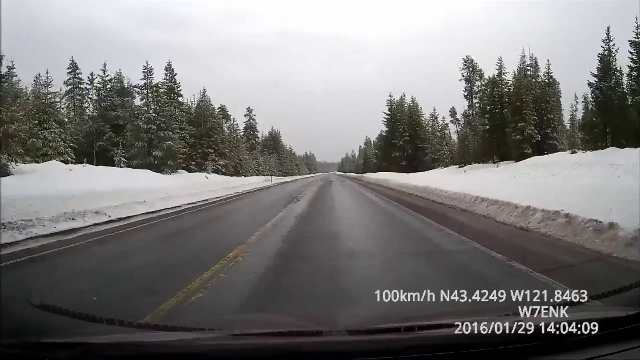

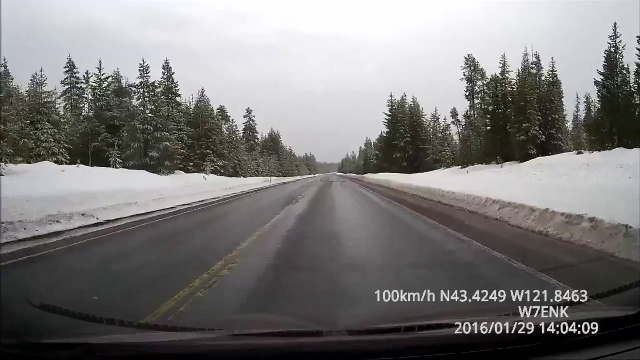

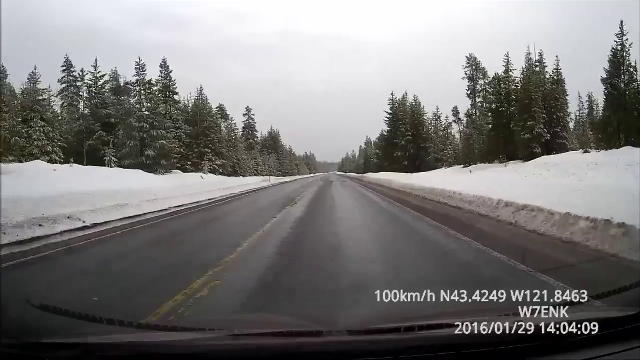

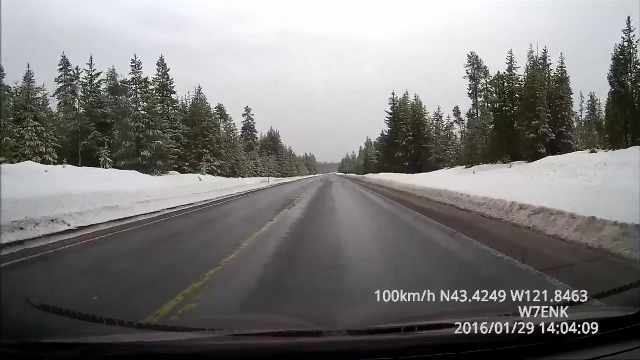

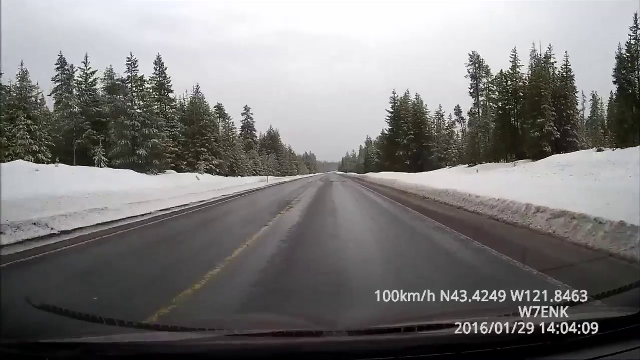

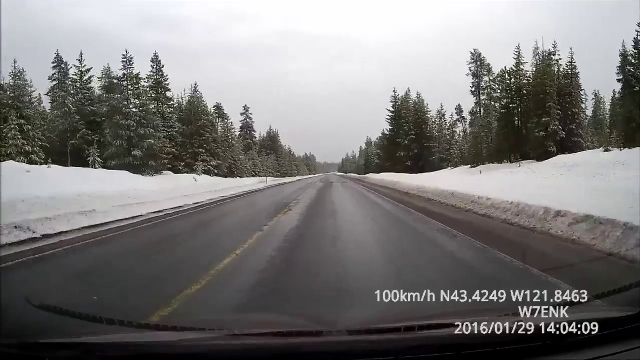

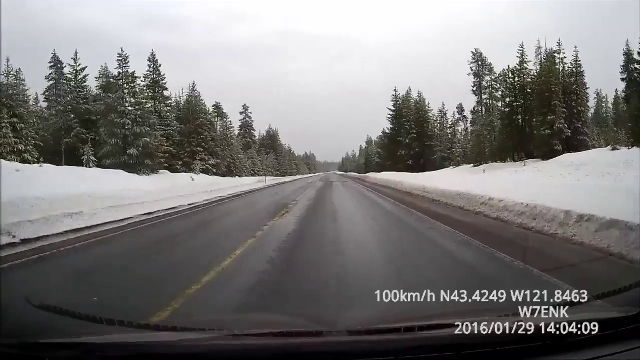

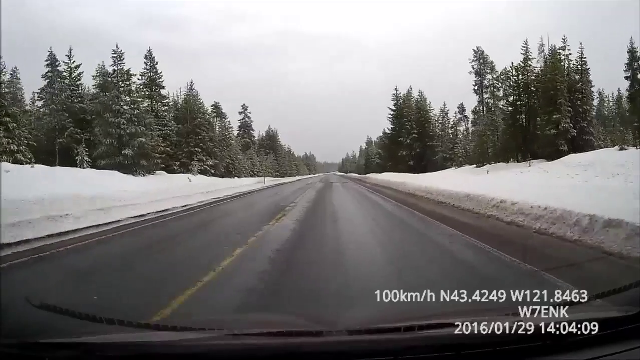

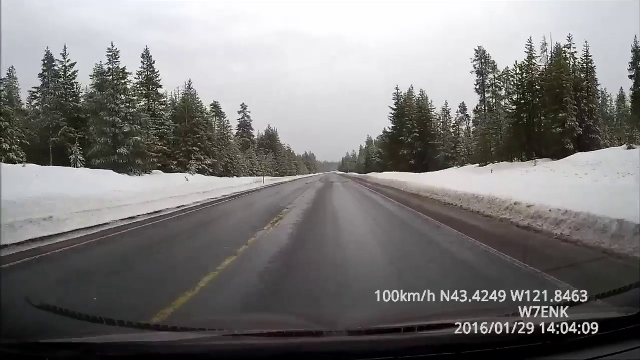

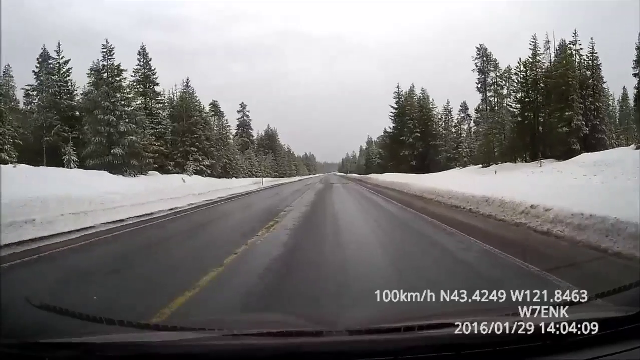

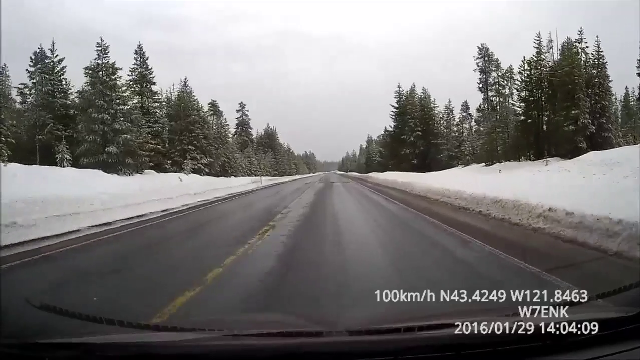

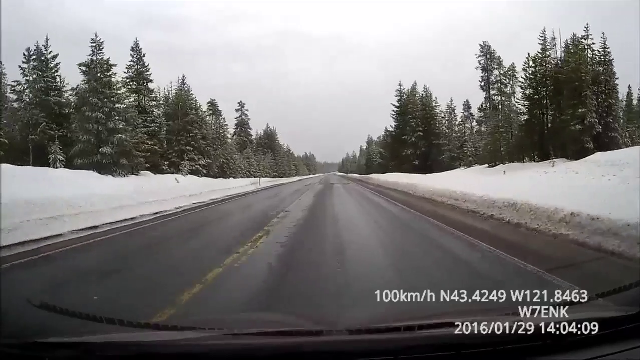

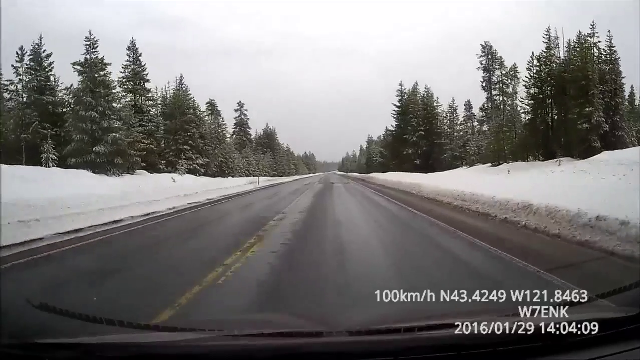

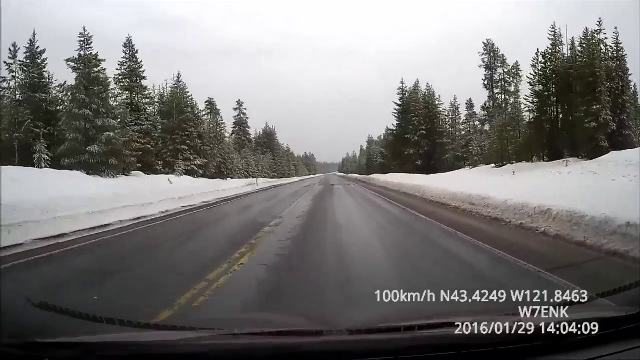

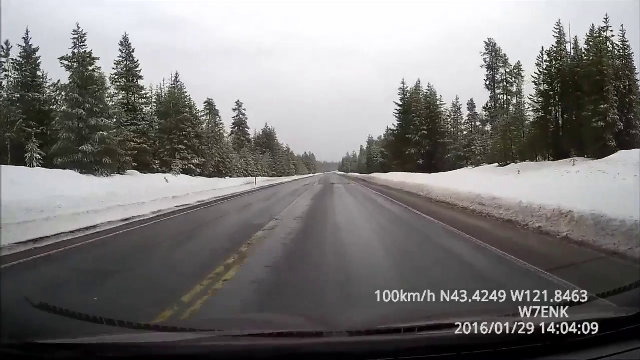

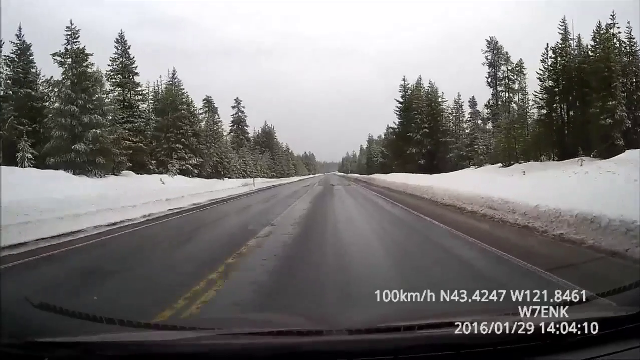

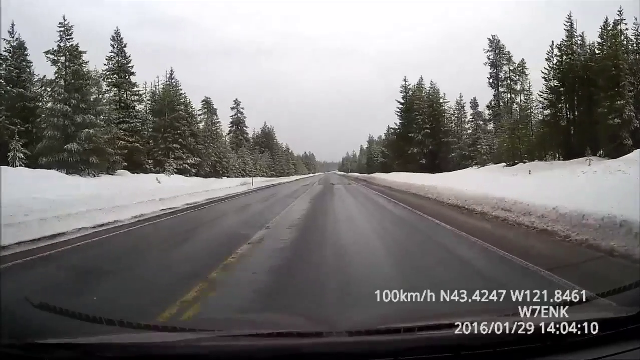

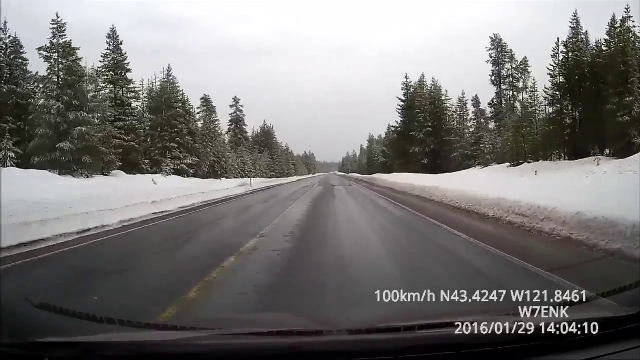

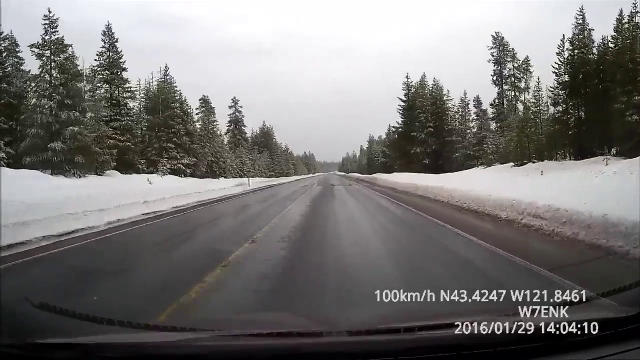

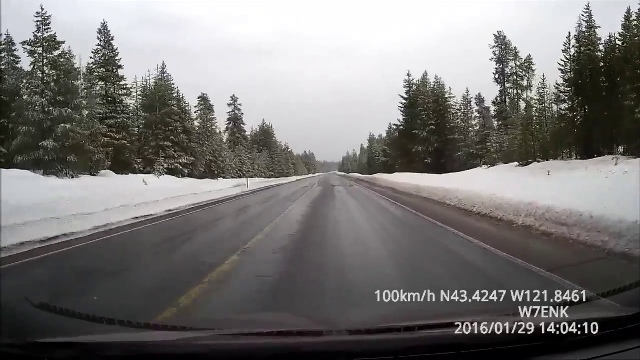

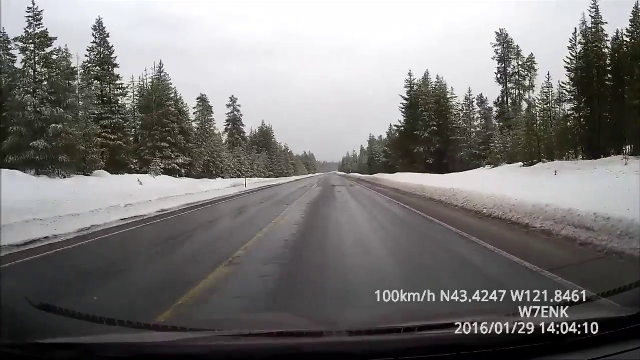

KeyboardInterrupt: ignored

In [12]:
from detectron2.utils.visualizer import ColorMode
from google.colab.patches import cv2_imshow
cap = cv2.VideoCapture('/content/drive/MyDrive/pothole.mp4')
while cap.isOpened():
  

  ret, image = cap.read()
  outputs = predictor(image)
  v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.5,instance_mode=ColorMode.SEGMENTATION)
  v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(v.get_image()[:, :, ::-1])